In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rolplay-fer-train/train/fear/Fear_3.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_8.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_10.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_2.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_6.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_9.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_11.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_1.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_7.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_4.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_0.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_5.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_12.jpg
/kaggle/input/rolplay-fer-train/train/fear/Fear_13.jpg
/kaggle/input/rolplay-fer-train/train/angry/cropped_emotions.232312~angry.png
/kaggle/input/rolplay-fer-train/train/angry/Anger_4.jpg
/kaggle/input/rolplay-fer-train/train/angry/cropped_emotions.232092~angry.png
/kaggle/input/rolplay-fer-tr

In [2]:
from tqdm import tqdm


In [3]:
!pip install albumentations  # if not installed yet

import albumentations as A  # import with the alias A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import os
import cv2
import numpy as np

# Ruta al directorio de entrada
input_folder = "/kaggle/input/rolplay-fer-train/train"


In [5]:
# Verificar que el directorio existe
if not os.path.exists(input_folder):
    print(f"Error: El directorio {input_folder} no existe")
else:
    print(f"Directorio encontrado: {input_folder}")

Directorio encontrado: /kaggle/input/rolplay-fer-train/train


In [6]:
    # Obtener lista de carpetas (clases)
    class_folders = sorted(os.listdir(input_folder))
    print(f"\nFolders encontrados ({len(class_folders)}):")
    
    total_images = 0
    
    for class_name in class_folders:
        class_path = os.path.join(input_folder, class_name)
        
        # Verificar que sea un directorio
        if os.path.isdir(class_path):
            # Contar imágenes en el folder
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            num_images = len(image_files)
            total_images += num_images
            
            # Obtener dimensiones de la primera imagen (si hay imágenes)
            if num_images > 0:
                sample_img_path = os.path.join(class_path, image_files[0])
                try:
                    img = cv2.imread(sample_img_path)
                    if img is not None:
                        img_shape = img.shape
                        print(f"- {class_name}: {num_images} imágenes, shape: {img_shape}")
                    else:
                        print(f"- {class_name}: {num_images} imágenes, error al leer muestra")
                except Exception as e:
                    print(f"- {class_name}: {num_images} imágenes, error: {str(e)}")
            else:
                print(f"- {class_name}: {num_images} imágenes")
    
    print(f"\nTotal de imágenes en el dataset: {total_images}")


Folders encontrados (9):
- Ahegao: 1205 imágenes, shape: (790, 577, 3)
- Contempt: 14 imágenes, shape: (3408, 2556, 3)
- angry: 1326 imágenes, shape: (252, 223, 3)
- disgust: 14 imágenes, shape: (3264, 2448, 3)
- fear: 14 imágenes, shape: (3264, 2448, 3)
- happy: 3753 imágenes, shape: (357, 357, 3)
- neutral: 4039 imágenes, shape: (357, 357, 3)
- sad: 3947 imágenes, shape: (958, 958, 3)
- surprised: 1248 imágenes, shape: (312, 187, 3)

Total de imágenes en el dataset: 15560


In [7]:
# Definir las clases a mantener (eliminando ahegao, contempt, disgust, fear)
classes_to_keep = ['angry', 'happy', 'neutral', 'sad', 'surprised']

In [8]:
# Definir el número objetivo de imágenes por clase
target_samples = 4000  # Aproximadamente el número de muestras en las clases mayoritarias

In [9]:
# Definir el pipeline de augmentation (más agresivo para clases minoritarias)
strong_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Rotate(limit=10, p=0.3),
    A.GaussNoise(var_limit=(3, 15), p=0.2),
    A.GaussianBlur(blur_limit=1, p=0.1),
    A.RandomGamma(gamma_limit=(95, 105), p=0.2),
    A.Perspective(scale=(0.01, 0.03), p=0.2),
    A.GridDistortion(p=0.1),
])

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:230: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [10]:
# Crear directorios de salida para el dataset balanceado
output_dir = "/kaggle/working/balanced_dataset"
for cls in classes_to_keep:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

In [11]:
# Procesar cada clase
for class_name in classes_to_keep:
    input_class_dir = os.path.join("/kaggle/input/rolplay-fer-train/train", class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    
    # Obtener archivos de imagen
    image_files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_original = len(image_files)
    
    print(f"Procesando clase {class_name}: {num_original} imágenes originales")
    
    # Copiar todas las imágenes originales
    for i, img_file in enumerate(tqdm(image_files, desc=f"Copiando originales de {class_name}")):
        img_path = os.path.join(input_class_dir, img_file)
        img = cv2.imread(img_path)
        
        # Resize a un tamaño estándar (224x224)
        img = cv2.resize(img, (224, 224))
        
        # Guardar imagen original
        cv2.imwrite(os.path.join(output_class_dir, f"orig_{img_file}"), img)
    
    # Calcular cuántas augmentations necesitamos
    augmentations_needed = max(0, target_samples - num_original)
    augmentations_per_image = int(np.ceil(augmentations_needed / num_original))
    
    # Solo hacer augmentation si es necesario
    if augmentations_needed > 0:
        print(f"Generando {augmentations_needed} imágenes adicionales para {class_name}")
        
        # Generar augmentaciones
        aug_count = 0
        for i, img_file in enumerate(tqdm(image_files, desc=f"Augmentando {class_name}")):
            if aug_count >= augmentations_needed:
                break
                
            img_path = os.path.join(input_class_dir, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
                
            for j in range(augmentations_per_image):
                if aug_count >= augmentations_needed:
                    break
                    
                # Aplicar augmentation
                augmented = strong_augmentation(image=img)["image"]
                
                # Resize a un tamaño estándar
                augmented = cv2.resize(augmented, (224, 224))
                
                # Guardar imagen aumentada
                aug_filename = f"aug_{j}_{img_file}"
                cv2.imwrite(os.path.join(output_class_dir, aug_filename), augmented)
                
                aug_count += 1

print("Procesamiento completado. Dataset balanceado creado en:", output_dir)

Procesando clase angry: 1326 imágenes originales


Copiando originales de angry: 100%|██████████| 1326/1326 [00:21<00:00, 60.88it/s]


Generando 2674 imágenes adicionales para angry


Augmentando angry:  67%|██████▋   | 892/1326 [00:32<00:15, 27.55it/s]


Procesando clase happy: 3753 imágenes originales


Copiando originales de happy: 100%|██████████| 3753/3753 [00:50<00:00, 73.88it/s]


Generando 247 imágenes adicionales para happy


Augmentando happy:   7%|▋         | 247/3753 [00:02<00:39, 89.24it/s] 


Procesando clase neutral: 4039 imágenes originales


Copiando originales de neutral: 100%|██████████| 4039/4039 [01:01<00:00, 66.14it/s]


Procesando clase sad: 3947 imágenes originales


Copiando originales de sad: 100%|██████████| 3947/3947 [00:56<00:00, 69.61it/s]


Generando 53 imágenes adicionales para sad


Augmentando sad:   1%|▏         | 53/3947 [00:00<00:38, 99.96it/s] 


Procesando clase surprised: 1248 imágenes originales


Copiando originales de surprised: 100%|██████████| 1248/1248 [00:22<00:00, 54.80it/s]


Generando 2752 imágenes adicionales para surprised


Augmentando surprised:  74%|███████▎  | 918/1248 [00:27<00:09, 33.47it/s]

Procesamiento completado. Dataset balanceado creado en: /kaggle/working/balanced_dataset


In [12]:
# Ruta al directorio del dataset balanceado
balanced_dataset = "/kaggle/working/balanced_dataset"

# Verificar que el directorio existe
if not os.path.exists(balanced_dataset):
    print(f"Error: El directorio {balanced_dataset} no existe")
else:
    print(f"Directorio encontrado: {balanced_dataset}")
    
    # Obtener lista de carpetas (clases)
    class_folders = sorted(os.listdir(balanced_dataset))
    print(f"\nFolders encontrados ({len(class_folders)}):")
    
    total_images = 0
    
    for class_name in class_folders:
        class_path = os.path.join(balanced_dataset, class_name)
        
        # Verificar que sea un directorio
        if os.path.isdir(class_path):
            # Contar imágenes en el folder
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            num_images = len(image_files)
            total_images += num_images
            
            # Obtener dimensiones de la primera imagen (si hay imágenes)
            if num_images > 0:
                sample_img_path = os.path.join(class_path, image_files[0])
                try:
                    img = cv2.imread(sample_img_path)
                    if img is not None:
                        img_shape = img.shape
                        print(f"- {class_name}: {num_images} imágenes, shape: {img_shape}")
                    else:
                        print(f"- {class_name}: {num_images} imágenes, error al leer muestra")
                except Exception as e:
                    print(f"- {class_name}: {num_images} imágenes, error: {str(e)}")
            else:
                print(f"- {class_name}: {num_images} imágenes")
    
    print(f"\nTotal de imágenes en el dataset balanceado: {total_images}")

Directorio encontrado: /kaggle/working/balanced_dataset

Folders encontrados (5):
- angry: 4000 imágenes, shape: (224, 224, 3)
- happy: 4000 imágenes, shape: (224, 224, 3)
- neutral: 4039 imágenes, shape: (224, 224, 3)
- sad: 4000 imágenes, shape: (224, 224, 3)
- surprised: 4000 imágenes, shape: (224, 224, 3)

Total de imágenes en el dataset balanceado: 20039


GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Configurando Mixed Precision (mixed_float16)
Iniciando script de entrenamiento...

=== DEPURACIÓN DEL PIPELINE DE DATOS ===
Uno o más directorios (train/val/test) no existen. Dividiendo dataset...
Creando directorio: /kaggle/working/balanced_dataset/train
Creando directorio: /kaggle/working/balanced_dataset/val
Creando directorio: /kaggle/working/balanced_dataset/test
Clases encontradas: ['happy', 'angry', 'neutral', 'surprised', 'sad']
Clase happy: 2723 train, 583 val, 585 test
Clase angry: 2789 train, 597 val, 599 test
Clase neutral: 2772 train, 594 val, 595 test
Clase surprised: 2797 train, 599 val, 600 test
Clase sad: 2723 train, 583 val, 585 test
Creando generador de entrenamiento desde: /kaggle/working/balanced_dataset/train
Found 13804 images belonging to 5 classes.
Creando generador de validación desde: /kaggle/working/balanced_d

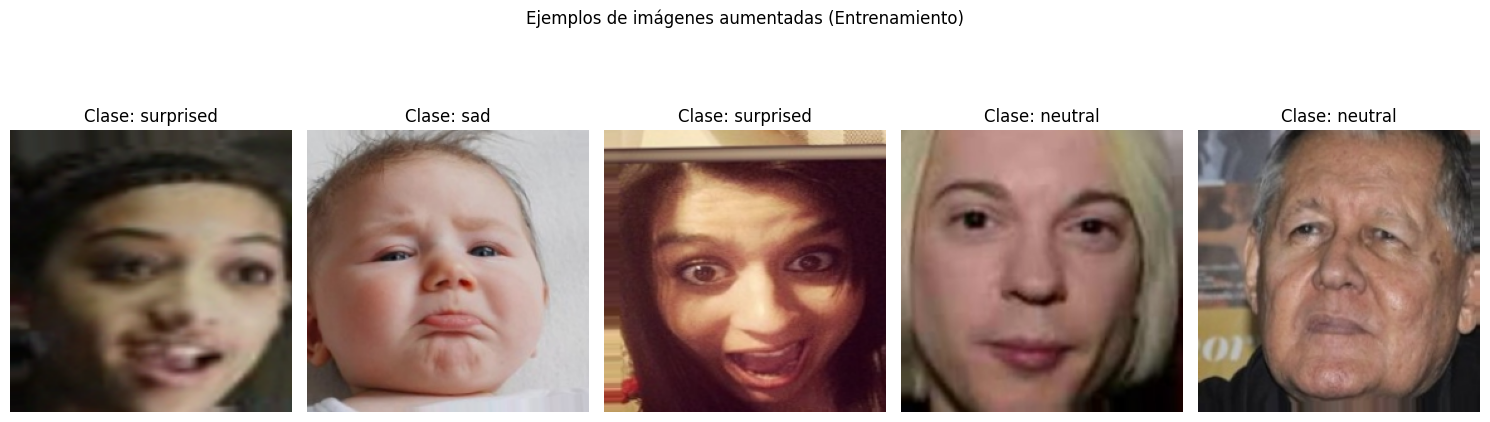


Pipeline de datos parece correcto.
Logs de TensorBoard se guardarán en: logs/fit/20250411-161139
Creando generador de entrenamiento desde: /kaggle/working/balanced_dataset/train
Found 13804 images belonging to 5 classes.
Creando generador de validación desde: /kaggle/working/balanced_dataset/val
Found 2956 images belonging to 5 classes.
Creando generador de prueba desde: /kaggle/working/balanced_dataset/test
Found 2964 images belonging to 5 classes.
Clases detectadas (5): ['angry', 'happy', 'neutral', 'sad', 'surprised']
Clases únicas encontradas en y_train: [0 1 2 3 4]
Número de clases esperado: 5
Pesos de clases a usar: {0: 0.9898888490498386, 1: 1.0138817480719795, 2: 0.9959595959595959, 3: 1.0138817480719795, 4: 0.9870575616732213}
Pasos por época (entrenamiento): 216
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Capas entrenables en base_model: 211
Calculando CosineDecay: initial_lr=0.0002, decay_steps=6480

=== RESUMEN DEL MODELO ===


Model: "EmotionClassifier_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,417,704 (16.85 MB)

 Trainable params: 4,372,353 (16.68 MB)

 Non-trainable params: 45,351 (177.16 KB)

Parámetros totales: 4,417,704

=== INICIANDO ENTRENAMIENTO ===
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4071 - auc: 0.7028 - f1_score: 0.4072 - loss: 1.8510 - precision: 0.4632 - recall: 0.3033

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_f1_score improved from -inf to 0.19747, saving model to model_checkpoints/best_model_epoch_01_val_f1_0.1975.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.4076 - auc: 0.7032 - f1_score: 0.4078 - loss: 1.8496 - precision: 0.4639 - recall: 0.3039 - val_accuracy: 0.2009 - val_auc: 0.4841 - val_f1_score: 0.1975 - val_loss: 1.7625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.7113 - auc: 0.9185 - f1_score: 0.7113 - loss: 1.1278 - precision: 0.7791 - recall: 0.6204
Epoch 2: val_f1_score did not improve from 0.19747
216/216 ━━━━━━━━━━━━━━━━━━━━ 185s 832ms/step - accuracy: 0.7114 - auc: 0.9185 - f1_score: 0.7114 - loss: 1.1276 - precision: 0.7792 - recall: 0.6205 - val_accuracy: 0.1915 - val_auc: 0.5348 - val_f1_score: 0.1910 - val_loss: 1.7657 - val_precision: 0.3478 - val_recall: 0.0027
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.8002 - auc: 0.9575 - f1_score: 0.800

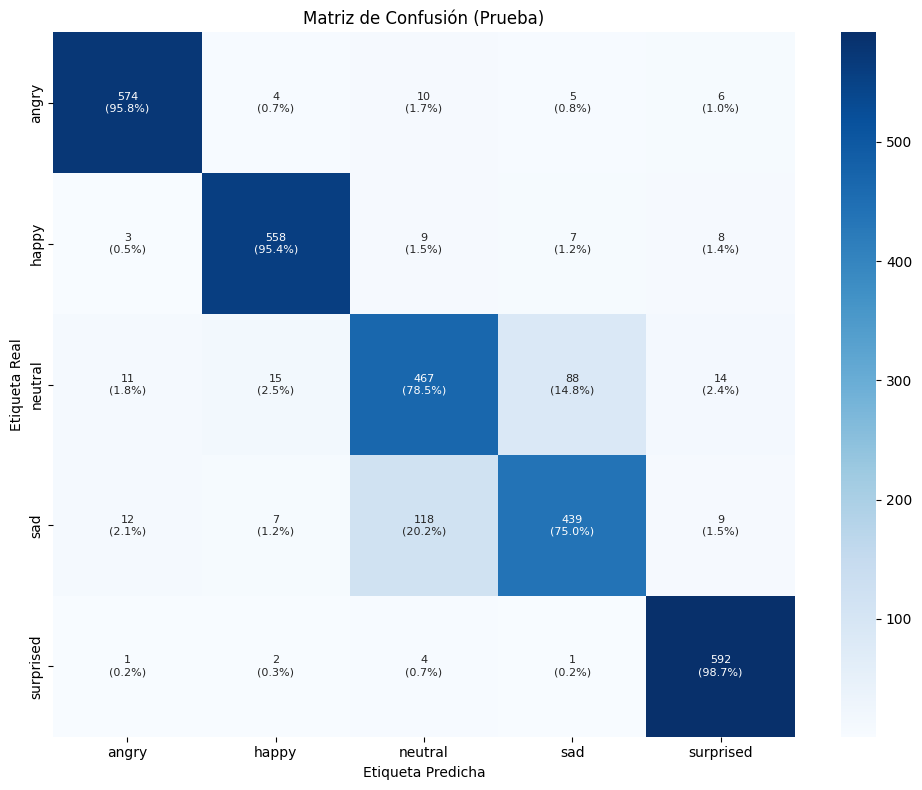

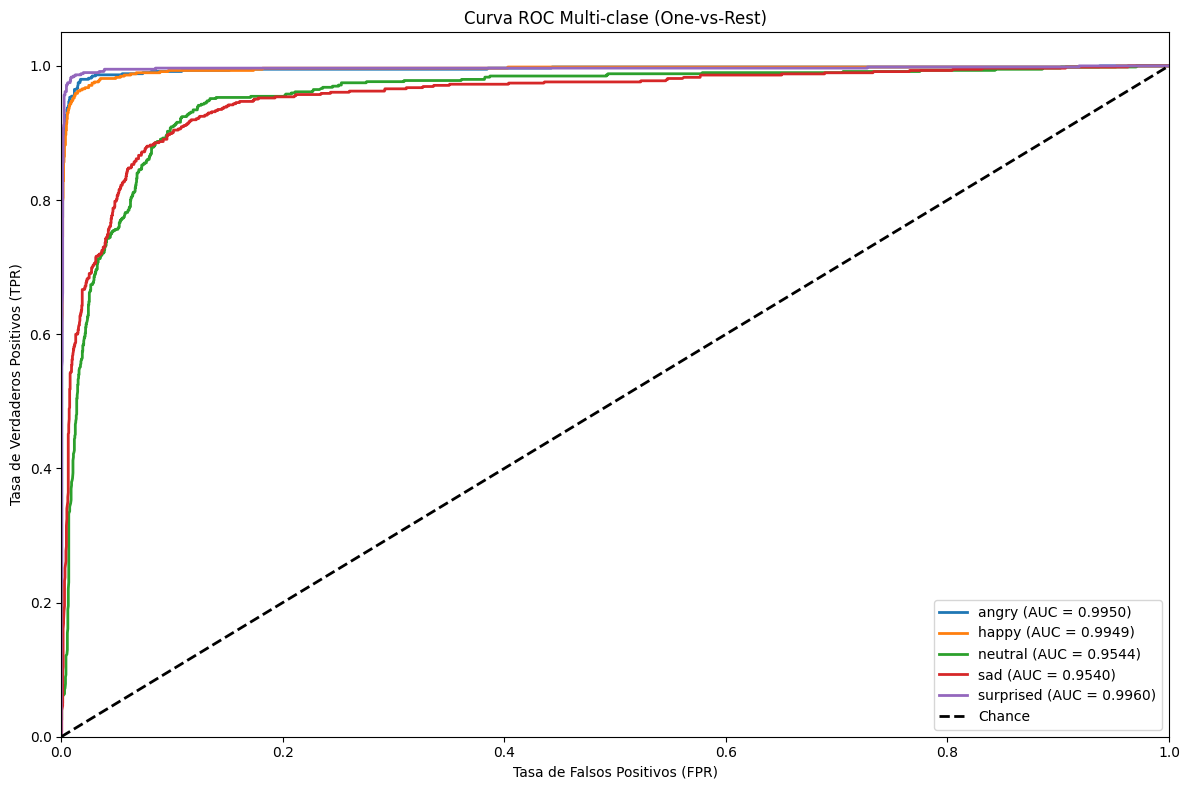


Ejemplos Incorrectamente Clasificados (Total: 334 de 2964)
Algunos ejemplos (índice, real, predicho, confianza):
- Índice 2073: Real=sad, Pred=neutral, Conf=54.64%
- Índice 1769: Real=neutral, Pred=sad, Conf=80.42%
- Índice 1733: Real=neutral, Pred=surprised, Conf=52.59%
- Índice 1822: Real=sad, Pred=neutral, Conf=89.75%
- Índice 2291: Real=sad, Pred=neutral, Conf=58.94%
- Índice 1676: Real=neutral, Pred=surprised, Conf=81.93%
- Índice 1427: Real=neutral, Pred=sad, Conf=78.27%
- Índice 2040: Real=sad, Pred=neutral, Conf=46.09%
- Índice 2259: Real=sad, Pred=surprised, Conf=90.23%
- Índice 1978: Real=sad, Pred=neutral, Conf=55.57%

Métricas Globales (Prueba):
- Accuracy: 0.8873
- Macro F1-Score: 0.8860
- Cohen's Kappa: 0.8591

Generando gráficas de historial de entrenamiento...


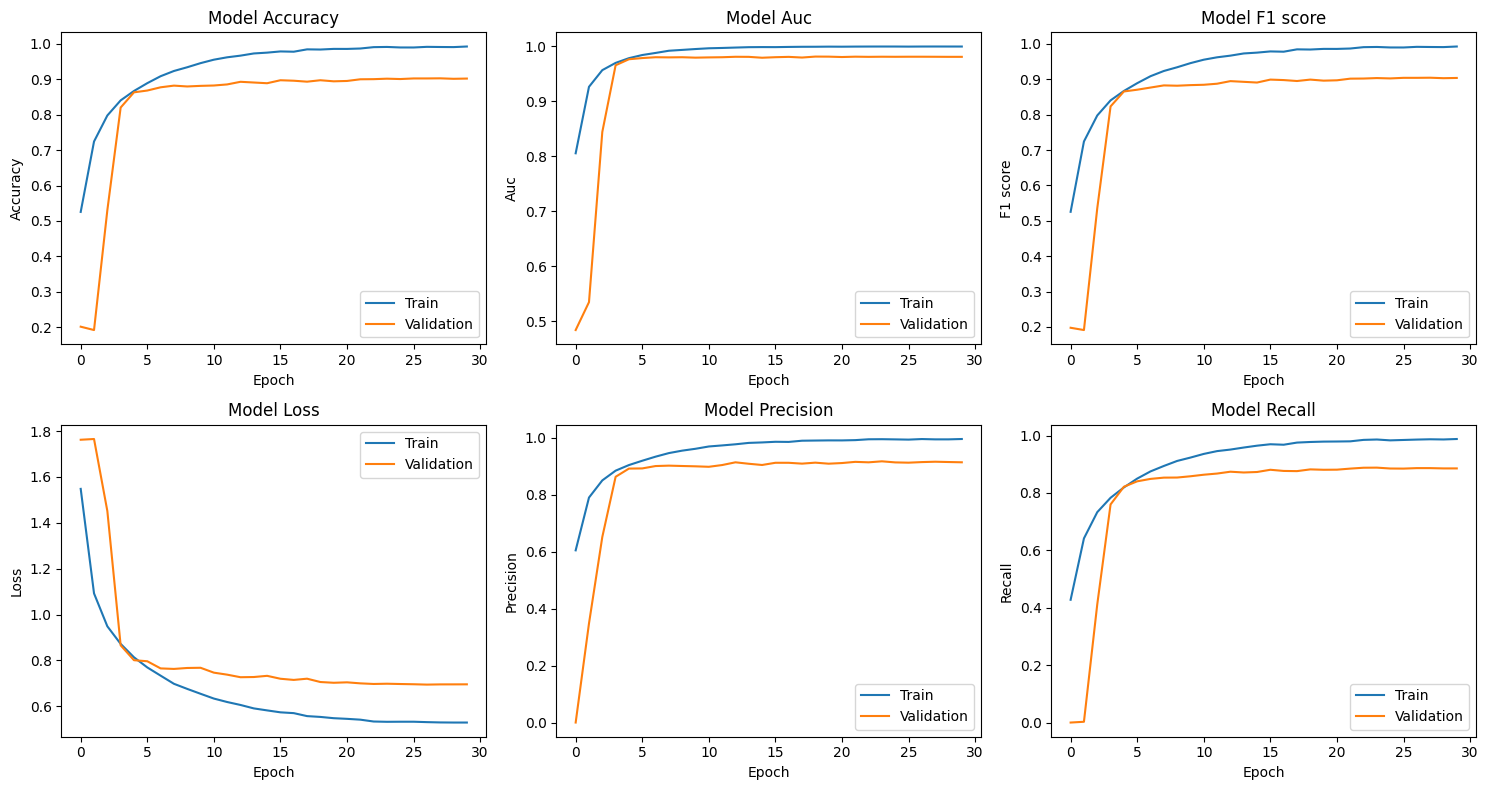


Mejor modelo (según val_f1_score) guardado como 'final_best_model.keras'
Capas entrenables en base_model: 211
Advertencia: train_steps_per_epoch no proporcionado. Usando LR fijo.
Modelo de inferencia guardado como 'final_best_model_inference.keras'

Entrenamiento completado.
Métricas finales detalladas en el conjunto de prueba:
              precision    recall  f1-score   support

       angry     0.9551    0.9583    0.9567       599
       happy     0.9522    0.9538    0.9530       585
     neutral     0.7681    0.7849    0.7764       595
         sad     0.8130    0.7504    0.7804       585
   surprised     0.9412    0.9867    0.9634       600

    accuracy                         0.8873      2964
   macro avg     0.8859    0.8868    0.8860      2964
weighted avg     0.8861    0.8873    0.8863      2964

Script finalizado.


In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from pathlib import Path
import pandas as pd
import datetime
import cv2

# Configuración inicial
DATASET_PATH = "/kaggle/working/balanced_dataset" # Asegúrate que esta ruta sea correcta
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 30 # EarlyStopping decidirá la duración real
NUM_CLASSES = 5 # Asegúrate que coincida con tus carpetas de clases
INITIAL_LR = 2e-4 # Mantenemos el LR inicial por ahora

# Verificar GPU y configurar mixed precision
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("Configurando Mixed Precision (mixed_float16)")
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
else:
    print("No GPU detected. Mixed precision not enabled.")

# Función para dividir el dataset en train/val/test
def split_dataset(dataset_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Divide el dataset en conjuntos de entrenamiento, validación y prueba manteniendo la estructura de clases
    """
    base_path = Path(dataset_path)
    train_dir = base_path / 'train'
    val_dir = base_path / 'val'
    test_dir = base_path / 'test'

    # Eliminar directorios si ya existen para empezar limpio
    for dir_path in [train_dir, val_dir, test_dir]:
        if dir_path.exists():
            print(f"Eliminando directorio existente: {dir_path}")
            shutil.rmtree(dir_path)
        print(f"Creando directorio: {dir_path}")
        dir_path.mkdir(parents=True, exist_ok=True)

    # Obtener clases de emociones (carpetas dentro del path base original)
    emotion_classes = [d for d in base_path.iterdir()
                       if d.is_dir() and d.name not in ['train', 'val', 'test']]
    if not emotion_classes:
         raise ValueError(f"No se encontraron carpetas de clases en {dataset_path}. "
                          f"Asegúrate de que las imágenes estén en subcarpetas con nombres de clase.")

    print(f"Clases encontradas: {[e.name for e in emotion_classes]}")

    for emotion_dir in emotion_classes:
        emotion_name = emotion_dir.name
        # Crear carpetas de emociones en cada división
        (train_dir / emotion_name).mkdir(exist_ok=True)
        (val_dir / emotion_name).mkdir(exist_ok=True)
        (test_dir / emotion_name).mkdir(exist_ok=True)

        # Obtener archivos de imágenes para esta emoción
        image_files = list(emotion_dir.glob('*.png')) + \
                      list(emotion_dir.glob('*.jpg')) + \
                      list(emotion_dir.glob('*.jpeg'))

        if not image_files:
            print(f"Advertencia: No se encontraron imágenes en {emotion_dir}")
            continue

        # Mezclar imágenes
        np.random.shuffle(image_files)

        # Calcular tamaños de división
        n_total = len(image_files)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        # n_test se calcula implícitamente

        # Dividir en train/val/test
        train_files = image_files[:n_train]
        val_files = image_files[n_train:n_train+n_val]
        test_files = image_files[n_train+n_val:]

        # Función auxiliar para copiar archivos
        def copy_files(files, destination_dir):
            dest_emotion_dir = destination_dir / emotion_name
            for f_path in files:
                try:
                    shutil.copy2(str(f_path), str(dest_emotion_dir / f_path.name))
                except Exception as e:
                    print(f"Error copiando {f_path} a {dest_emotion_dir}: {e}")

        # Copiar archivos a los directorios respectivos
        copy_files(train_files, train_dir)
        copy_files(val_files, val_dir)
        copy_files(test_files, test_dir)

        print(f"Clase {emotion_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

    return str(train_dir), str(val_dir), str(test_dir)

# Métricas extendidas con casting adecuado para mixed precision
@tf.keras.utils.register_keras_serializable() # Para guardar/cargar modelo
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    # y_pred viene de la salida softmax (probabilidades), necesitamos convertirla a one-hot
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_pred_one_hot = tf.one_hot(y_pred_labels, depth=tf.shape(y_pred)[-1])
    y_pred = tf.cast(y_pred_one_hot, tf.float32) # Usar predicción dura para métricas estándar

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Función para calcular pesos de clases para manejar desbalance
def calculate_class_weights(y_train, num_classes):
    """Calcula los pesos de clase balanceados."""
    classes = np.arange(num_classes) # Asegurar que todas las clases 0..N-1 están consideradas
    y_unique = np.unique(y_train)
    print(f"Clases únicas encontradas en y_train: {y_unique}")
    print(f"Número de clases esperado: {num_classes}")

    # Verificar si todas las clases están presentes
    if not np.array_equal(np.sort(y_unique), np.arange(num_classes)):
        print(f"Advertencia: No todas las clases (0 a {num_classes-1}) están presentes en y_train. "
              f"Clases presentes: {y_unique}. Esto puede afectar compute_class_weight.")

    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=classes, # Usar el rango completo esperado
        y=y_train
    )
    # Convertir a diccionario {class_index: weight}
    class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

    # Asegurar que todas las clases esperadas tengan un peso
    for i in range(num_classes):
        if i not in class_weights:
            print(f"Advertencia: Clase {i} no encontrada en y_train. Asignando peso 1.0.")
            class_weights[i] = 1.0

    return class_weights


# Cargar generadores de datos con augmentación equilibrada
def load_generators(dataset_path=DATASET_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """Carga los generadores de datos para train, val y test."""
    train_dir_path = Path(dataset_path) / 'train'
    val_dir_path = Path(dataset_path) / 'val'
    test_dir_path = Path(dataset_path) / 'test'

    # Verificar si existen los directorios train/val/test o crearlos
    if not train_dir_path.exists() or not val_dir_path.exists() or not test_dir_path.exists():
        print("Uno o más directorios (train/val/test) no existen. Dividiendo dataset...")
        try:
            split_dataset(dataset_path)
            # Reasignar rutas después de crear los directorios
            train_dir_path = Path(dataset_path) / 'train'
            val_dir_path = Path(dataset_path) / 'val'
            test_dir_path = Path(dataset_path) / 'test'
            if not train_dir_path.exists(): # Doble chequeo
                 raise FileNotFoundError("El directorio de entrenamiento no se creó correctamente.")
        except Exception as e:
            print(f"Error durante la división del dataset: {e}")
            raise # Detener si la división falla

    # Parámetros de augmentación (se mantienen igual por ahora)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.03,
        zoom_range=0.05,
        horizontal_flip=True,
        brightness_range=(0.95, 1.05),
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Crear generadores
    print(f"Creando generador de entrenamiento desde: {train_dir_path}")
    train_gen = train_datagen.flow_from_directory(
        str(train_dir_path),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    print(f"Creando generador de validación desde: {val_dir_path}")
    val_gen = val_test_datagen.flow_from_directory(
        str(val_dir_path),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False # No barajar val/test para métricas consistentes
    )

    print(f"Creando generador de prueba desde: {test_dir_path}")
    test_gen = val_test_datagen.flow_from_directory(
        str(test_dir_path),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Verificar si se cargaron imágenes
    if train_gen.samples == 0:
        raise ValueError(f"No se encontraron imágenes en el directorio de entrenamiento: {train_dir_path}")
    if val_gen.samples == 0:
        print(f"Advertencia: No se encontraron imágenes en el directorio de validación: {val_dir_path}")
    if test_gen.samples == 0:
        print(f"Advertencia: No se encontraron imágenes en el directorio de prueba: {test_dir_path}")

    return train_gen, val_gen, test_gen

# Modelo con regularizaciones REDUCIDAS usando AdamW y Cosine Decay
def build_model(input_shape=(*IMG_SIZE, 3), num_classes=NUM_CLASSES, learning_rate=INITIAL_LR,
                train_steps_per_epoch=None, epochs=EPOCHS, is_training=True):
    """Construye el modelo con regularización reducida."""
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Hacemos toda la base entrenable (fine-tuning)
    base_model.trainable = True
    print(f"Capas entrenables en base_model: {len(base_model.trainable_variables)}")

    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # IMPORTANTE: Usar is_training para controlar el comportamiento
    x = base_model(x, training=is_training)

    # Capas superiores con regularización REDUCIDA
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x) # BN después de GAP

    # Primera capa densa con L2 y activity reducidos, Dropout reducido
    x = layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=l2(1e-4),  # L2 Reducido
        activity_regularizer=l2(1e-6), # Activity Reducido
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(x)
    x = layers.BatchNormalization()(x) # BN después de Dense+activation
    x = layers.Dropout(0.3)(x)  # Dropout Reducido

    # Segunda capa con L2 y activity reducidos, Dropout reducido
    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=l2(1e-4), # L2 Reducido
        activity_regularizer=l2(1e-6), # Activity Reducido
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x) # Dropout Reducido

    # Capa de salida (softmax para clasificación multiclase)
    outputs = layers.Dense(
        num_classes,
        activation='softmax', # Softmax directo
        kernel_regularizer=l2(1e-5)
    )(x)

    model = tf.keras.Model(inputs, outputs, name="EmotionClassifier_EfficientNetB0")

    # Configurar Learning Rate Schedule con Cosine Decay
    if train_steps_per_epoch is not None:
        total_steps = epochs * train_steps_per_epoch
        print(f"Calculando CosineDecay: initial_lr={learning_rate}, decay_steps={total_steps}")
        lr_schedule = CosineDecay(
            initial_learning_rate=learning_rate,
            decay_steps=total_steps,
            alpha=1e-6 # LR mínimo al final del decay
        )
    else:
        print("Advertencia: train_steps_per_epoch no proporcionado. Usando LR fijo.")
        lr_schedule = learning_rate

    # Compilar con AdamW (weight_decay reducido) y label smoothing
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule, # Usar Cosine Decay schedule
        weight_decay=1e-5,  # Weight Decay Reducido
        clipnorm=1.0 # Mantenemos clipping para estabilidad
    )

    # Compilar el modelo
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Mantener label smoothing
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            f1_score, # Usar la métrica personalizada
            tf.keras.metrics.AUC(name='auc', multi_label=True) # AUC para multiclase
        ]
    )

    return model

# FUNCIÓN CORREGIDA: Crea un modelo específico para inferencia (training=False)
def create_inference_model(trained_model):
    """
    Crea un modelo dedicado para inferencia con training=False
    """
    # En lugar de usar tf.function, simplemente vamos a crear un nuevo modelo
    # usando la misma función build_model pero con is_training=False
    
    # Obtener la configuración del modelo original
    input_shape = trained_model.input_shape[1:]
    
    # Crear un nuevo modelo con la misma arquitectura pero training=False
    inference_model = build_model(
        input_shape=input_shape,
        num_classes=NUM_CLASSES,
        learning_rate=INITIAL_LR,
        is_training=False  # IMPORTANTE: Esto es lo que hace la diferencia
    )
    
    # Copiar los pesos del modelo original
    inference_model.set_weights(trained_model.get_weights())
    
    return inference_model

# Función para cargar un modelo para inferencia
def load_model_for_inference(model_path):
    """Carga un modelo para inferencia con las configuraciones correctas."""
    # Definir objetos personalizados necesarios para cargar el modelo
    custom_objects = {
        'f1_score': f1_score
    }
    
    try:
        # Cargar el modelo
        model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
        print(f"Modelo cargado exitosamente: {model_path}")
        
        # Crear modelo específico para inferencia
        inference_model = create_inference_model(model)
        print("Modelo de inferencia creado correctamente con training=False")
        
        return inference_model
    
    except Exception as e:
        print(f"Error al cargar el modelo: {e}")
        return None

# Función para visualizar curvas de aprendizaje (sin cambios)
def plot_training_history(history, metrics_to_plot=None):
    """Plot comprehensive training history curves"""
    if metrics_to_plot is None:
        # Detectar métricas disponibles que tengan 'val_' counterpart
        available_metrics = [k for k in history.history.keys() if not k.startswith('val_') and f'val_{k}' in history.history]
        metrics_to_plot = available_metrics

    num_metrics = len(metrics_to_plot)
    if num_metrics == 0:
        print("No metrics suitable for plotting found in history.")
        return

    # Ajustar layout de subplots
    cols = 3
    rows = (num_metrics + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 4))

    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(rows, cols, i + 1)
        # Verificar si la métrica existe antes de plotear
        if metric in history.history and f'val_{metric}' in history.history:
            plt.plot(history.history[metric], label='Train')
            plt.plot(history.history[f'val_{metric}'], label='Validation')
            plt.title(f'Model {metric.replace("_", " ").capitalize()}')
            plt.ylabel(metric.replace("_", " ").capitalize())
            plt.xlabel('Epoch')
            plt.legend(loc='best')
        else:
            print(f"Skipping plot for metric '{metric}' as train or validation data is missing.")

    plt.tight_layout()
    plt.show()


# Función para evaluación detallada del modelo
def evaluate_model_detailed(model, test_gen, class_names):
    """Evalúa el modelo en detalle en el conjunto de prueba."""
    print("\n=== EVALUACIÓN DETALLADA DEL MODELO (Conjunto de Prueba) ===\n")

    # 1. Obtener predicciones
    print("Generando predicciones en el conjunto de prueba...")
    # Reiniciar generador para asegurar orden correcto
    test_gen.reset()
    try:
        # Hacer predicciones
        y_pred_prob = model.predict(test_gen, verbose=1, steps=len(test_gen))
        
        # Verificar NaN en predicciones
        if np.isnan(y_pred_prob).any():
            print("ADVERTENCIA: Se detectaron valores NaN en las predicciones. Usando estado actual del modelo con float32.")
            # Cambiar a float32 y reintentar
            original_policy = tf.keras.mixed_precision.global_policy()
            tf.keras.mixed_precision.set_global_policy('float32')
            test_gen.reset()
            y_pred_prob = model.predict(test_gen, verbose=1, steps=len(test_gen))
            tf.keras.mixed_precision.set_global_policy(original_policy)
            
            # Verificar nuevamente
            if np.isnan(y_pred_prob).any():
                print("ERROR: Todavía hay valores NaN. Se recomienda reentrenar en float32.")
                return None
            else:
                print("Usando float32 se resolvieron los valores NaN.")
    except Exception as e:
        print(f"Error durante model.predict: {e}")
        return None # Salir si la predicción falla

    if len(y_pred_prob) != test_gen.samples:
         print(f"Advertencia: El número de predicciones ({len(y_pred_prob)}) "
               f"no coincide con el número de muestras en test_gen ({test_gen.samples}).")

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes[:len(y_pred)] # Asegurar que tengan la misma longitud

    # 2. Informe de clasificación detallado
    print("\nInforme de clasificación:")
    # Usar zero_division=0 para evitar warnings si una clase no tiene predicciones/etiquetas
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0)
    print(report)

    # 3. Matriz de confusión con etiquetas
    plt.figure(figsize=(10, 8))
    try:
        cm = confusion_matrix(y_true, y_pred)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        # Evitar división por cero si una fila suma 0
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_percent = cm.astype('float') / cm_sum * 100
            cm_percent = np.nan_to_num(cm_percent) # Reemplazar NaN con 0

        annot = np.empty_like(cm, dtype=object) # Usar object para strings
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

        sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8}) # Ajustar tamaño de fuente
        plt.title('Matriz de Confusión (Prueba)')
        plt.ylabel('Etiqueta Real')
        plt.xlabel('Etiqueta Predicha')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generando matriz de confusión: {e}")


    # 5. Curvas ROC por clase (one-vs-rest)
    plt.figure(figsize=(12, 8))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        # One-hot encode y_true para la clase i
        y_true_class = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))[:, i]
        y_score = y_pred_prob[:, i]

        if np.sum(y_true_class) > 0: # Solo calcular si hay etiquetas positivas para la clase
             fpr[i], tpr[i], _ = roc_curve(y_true_class, y_score)
             roc_auc[i] = auc(fpr[i], tpr[i])
             plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')
        else:
             print(f"Skipping ROC curve for class '{class_names[i]}' as there are no true samples.")


    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC Multi-clase (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # 6. Ejemplos incorrectamente clasificados
    misclassified_indices = np.where(y_pred != y_true)[0]

    if len(misclassified_indices) > 0:
        print(f"\nEjemplos Incorrectamente Clasificados (Total: {len(misclassified_indices)} de {len(y_true)})")

        # Obtener hasta 10 ejemplos aleatorios
        sample_size = min(10, len(misclassified_indices))
        sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

        # Solo imprimir información textual si no se muestran imágenes
        print("Algunos ejemplos (índice, real, predicho, confianza):")
        for idx in sample_indices:
            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred[idx]]
            confidence = y_pred_prob[idx, y_pred[idx]] * 100
            print(f"- Índice {idx}: Real={true_label}, Pred={pred_label}, Conf={confidence:.2f}%")

    # 7. Métricas generales
    accuracy = np.mean(y_pred == y_true)
    # Calcular Macro F1 desde el reporte para consistencia
    report_dict = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True, zero_division=0)
    macro_f1 = report_dict['macro avg']['f1-score']
    kappa = cohen_kappa_score(y_true, y_pred)

    print("\nMétricas Globales (Prueba):")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- Macro F1-Score: {macro_f1:.4f}")
    print(f"- Cohen's Kappa: {kappa:.4f}")

    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'kappa': kappa,
        'classification_report': report,
        'confusion_matrix': cm if 'cm' in locals() else None
    }


# Función para depurar el pipeline de datos
def debug_data_pipeline():
    """Verifica el pipeline de datos y muestra información de diagnóstico."""
    print("\n=== DEPURACIÓN DEL PIPELINE DE DATOS ===")
    try:
        train_gen, val_gen, test_gen = load_generators()

        print(f"\nGenerador de Entrenamiento:")
        print(f"- Número de imágenes: {train_gen.samples}")
        print(f"- Número de clases: {train_gen.num_classes}")
        print(f"- Índices de clases: {train_gen.class_indices}")
        class_names = list(train_gen.class_indices.keys())

        # Verificar la distribución de clases en entrenamiento
        print("\nDistribución de clases (entrenamiento):")
        class_counts = np.bincount(train_gen.classes)
        for i, (name, count) in enumerate(zip(class_names, class_counts)):
            print(f"- Clase {i} ({name}): {count} imágenes")

        # Verificar los pesos de las clases
        class_weights = calculate_class_weights(train_gen.classes, train_gen.num_classes)
        print("\nPesos de clases calculados:")
        for i, name in enumerate(class_names):
            print(f"- Clase {i} ({name}): {class_weights.get(i, 'N/A'):.4f}") # Usar get para seguridad

        # Verificar shapes y tipos de datos de un batch
        print("\nVerificación de batch (entrenamiento):")
        X_batch, y_batch = next(train_gen)
        print(f"- X_batch shape: {X_batch.shape}")
        print(f"- X_batch dtype: {X_batch.dtype}")
        # Verificar rango de píxeles (debe estar cerca de 0-1 si rescale=1./255)
        print(f"- X_batch min/max: {X_batch.min():.4f} / {X_batch.max():.4f}")
        print(f"- y_batch shape: {y_batch.shape}")
        print(f"- y_batch dtype: {y_batch.dtype}")

        # Visualizar algunas imágenes aumentadas
        print("\nVisualizando ejemplos aumentados:")
        plt.figure(figsize=(15, 5))
        num_examples_to_show = min(5, BATCH_SIZE) # Mostrar hasta 5
        for i in range(num_examples_to_show):
            plt.subplot(1, num_examples_to_show, i + 1)
            plt.imshow(X_batch[i]) # Asume que los valores están en [0, 1]
            cls_index = np.argmax(y_batch[i])
            plt.title(f"Clase: {class_names[cls_index]}")
            plt.axis('off')
        plt.suptitle("Ejemplos de imágenes aumentadas (Entrenamiento)")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para suptitle
        plt.show()

        print("\nPipeline de datos parece correcto.")

    except Exception as e:
        print(f"\nError durante la depuración del pipeline de datos: {e}")
        import traceback
        traceback.print_exc() # Imprimir stack trace completo

    print("===================================")


# Función de entrenamiento mejorada
def train(dataset_path=DATASET_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE,
          epochs=EPOCHS, learning_rate=INITIAL_LR):
    """Función de entrenamiento principal."""

    # Crear directorio de logs para TensorBoard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print(f"Logs de TensorBoard se guardarán en: {log_dir}")

    # Cargar datos
    try:
        train_gen, val_gen, test_gen = load_generators(
            dataset_path=dataset_path,
            img_size=img_size,
            batch_size=batch_size
        )
    except Exception as e:
        print(f"Fallo al cargar los generadores de datos: {e}")
        return None, None, None # Salir si falla la carga

    # Obtener nombres y número de clases desde el generador
    class_names = list(train_gen.class_indices.keys())
    num_classes_actual = train_gen.num_classes
    print(f"Clases detectadas ({num_classes_actual}): {class_names}")
    # Actualizar NUM_CLASSES global si es diferente (aunque es mejor pasarlo como argumento)
    global NUM_CLASSES
    if NUM_CLASSES != num_classes_actual:
        print(f"Advertencia: NUM_CLASSES global ({NUM_CLASSES}) no coincide con detectado ({num_classes_actual}). Usando {num_classes_actual}.")
        NUM_CLASSES = num_classes_actual


    # Calcular class weights
    class_weights = calculate_class_weights(train_gen.classes, num_classes_actual)
    print("Pesos de clases a usar:", class_weights)

    # Calcular pasos por época para el LR schedule
    train_steps_per_epoch = len(train_gen)
    print(f"Pasos por época (entrenamiento): {train_steps_per_epoch}")

    # Construir modelo con training=True para entrenamiento
    model = build_model(
        input_shape=(*img_size, 3),
        num_classes=num_classes_actual,
        learning_rate=learning_rate,
        train_steps_per_epoch=train_steps_per_epoch,
        epochs=epochs,
        is_training=True
    )

    # Mostrar resumen del modelo
    print("\n=== RESUMEN DEL MODELO ===")
    model.summary()
    print(f"Parámetros totales: {model.count_params():,}")

    # Callbacks
    # Crear directorio para guardar modelos si no existe
    model_save_dir = Path("./model_checkpoints")
    model_save_dir.mkdir(parents=True, exist_ok=True)
    # Usar .keras para el nuevo formato
    checkpoint_path = model_save_dir / "best_model_epoch_{epoch:02d}_val_f1_{val_f1_score:.4f}.keras"

    callbacks = [
        ModelCheckpoint(
            filepath=str(checkpoint_path),
            save_best_only=True,
            monitor='val_f1_score', # Monitorear F1 en validación
            mode='max', # Queremos maximizar F1
            verbose=1
        ),
        EarlyStopping(
            monitor='val_f1_score', # Monitorear lo mismo que ModelCheckpoint
            patience=7, # Número de épocas sin mejora antes de parar
            mode='max',
            restore_best_weights=True, # Restaurar pesos del mejor epoch al final
            verbose=1
        ),
        tensorboard_callback
    ]

    # Entrenamiento
    print("\n=== INICIANDO ENTRENAMIENTO ===")
    history = model.fit(
        train_gen,
        epochs=epochs, # Número máximo de épocas
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weights, # Aplicar pesos de clase
        verbose=1
    )

    # Evaluación después del entrenamiento (EarlyStopping restaura los mejores pesos)
    print("\n=== EVALUACIÓN POST-ENTRENAMIENTO (Mejor Modelo en Validación) ===")

    # Evaluación en conjunto de prueba
    print("\nEvaluando en conjunto de prueba...")
    if test_gen.samples > 0:
        # Crear modelo de inferencia para evaluación
        print("Creando modelo de inferencia para evaluación...")
        model_inference = create_inference_model(model)
        
        test_results = model_inference.evaluate(test_gen, verbose=1, steps=len(test_gen))
        print("\nResultados en Prueba (Métricas del Modelo):")
        metrics_names = model_inference.metrics_names
        for name, value in zip(metrics_names, test_results):
            print(f"- {name}: {value:.4f}")

        # Evaluación detallada en prueba
        detailed_metrics = evaluate_model_detailed(model_inference, test_gen, class_names)
    else:
        print("No hay datos de prueba para evaluar.")
        detailed_metrics = None

    # Visualizar curvas de aprendizaje
    print("\nGenerando gráficas de historial de entrenamiento...")
    plot_training_history(history)

    # Guardar el modelo final (que tiene los mejores pesos restaurados por EarlyStopping)
    final_model_path = 'final_best_model.keras'
    model.save(final_model_path)
    print(f"\nMejor modelo (según val_f1_score) guardado como '{final_model_path}'")

    # También guardar un modelo específico para inferencia
    inference_model_path = 'final_best_model_inference.keras'
    create_inference_model(model).save(inference_model_path)
    print(f"Modelo de inferencia guardado como '{inference_model_path}'")

    return model, detailed_metrics, history

# Función para predecir emociones en imágenes individuales
def predict_emotion(model, image_path=None, image=None, class_names=None):
    """
    Predice la emoción para una imagen.
    
    Args:
        model: Modelo cargado
        image_path: Ruta a la imagen (opcional)
        image: Imagen ya cargada como array (opcional)
        class_names: Lista de nombres de clases
    
    Returns:
        Diccionario con resultados de predicción
    """
    if class_names is None:
        class_names = ['angry', 'happy', 'neutral', 'sad', 'surprised']
    
    # Cargar imagen si se proporciona path
    if image_path is not None:
        image = cv2.imread(image_path)
        if image is None:
            return {"error": f"No se pudo cargar la imagen desde {image_path}"}
    
    if image is None:
        return {"error": "No se proporcionó imagen"}
    
    # Preprocesar la imagen
    image_resized = cv2.resize(image, IMG_SIZE)
    image_normalized = image_resized.astype('float32') / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)
    
    # Hacer predicción con training=False
    try:
        predictions = model(image_batch, training=False).numpy()
        
        # Verificar NaN
        if np.isnan(predictions).any():
            return {"error": "Se detectaron valores NaN en las predicciones"}
        
        # Obtener clase y confianza
        predicted_class_idx = np.argmax(predictions[0])
        confidence = float(predictions[0][predicted_class_idx])
        
        return {
            "emotion": class_names[predicted_class_idx],
            "confidence": confidence,
            "all_confidences": {name: float(predictions[0][i]) for i, name in enumerate(class_names)}
        }
    except Exception as e:
        return {"error": f"Error durante la predicción: {str(e)}"}

# --- Ejecución Principal ---
if __name__ == "__main__":
    print("Iniciando script de entrenamiento...")
    
    # 1. Depurar el pipeline de datos ANTES de entrenar
    debug_data_pipeline()

    # 2. Entrenar el modelo
    model, metrics, history = train()

    # 3. (Opcional) Realizar acciones adicionales con el modelo o métricas
    if model and metrics:
        print("\nEntrenamiento completado.")
        print("Métricas finales detalladas en el conjunto de prueba:")
        # Imprimir reporte de clasificación si existe
        if metrics.get('classification_report'):
             print(metrics['classification_report'])
    elif model:
        print("\nEntrenamiento completado, pero no se pudo evaluar en prueba (posiblemente no hay datos de prueba).")
    else:
        print("\nEl entrenamiento falló o fue interrumpido.")

    print("Script finalizado.")

In [14]:
# --- Guardado del modelo YA ENTRENADO (ejecutar en una nueva celda) ---

# Asegúrate de que la variable 'model' (o como la hayas llamado al recibirla de train())
# contenga tu modelo entrenado con los mejores pesos ya restaurados.

if 'model' in locals() and isinstance(model, tf.keras.Model):
    print(f"Guardando el modelo '{model.name}' que está en memoria...")

    # 1. Guardar en formato Keras v3 (.keras) - RECOMENDADO
    model_path_keras = 'final_trained_model.keras'
    model.save(model_path_keras)
    print(f"Modelo guardado en formato .keras: {model_path_keras}")

    # 2. Guardar en formato HDF5 (.h5) - LEGACY
    model_path_h5 = 'final_trained_model.h5'
    try:
        model.save(model_path_h5, save_format='h5')
        print(f"Modelo guardado en formato .h5: {model_path_h5}")
    except Exception as e:
        print(f"\nADVERTENCIA: Falló el guardado en formato .h5: {e}")
        print("--> Es preferible usar el archivo .keras guardado.")

else:
    print("ERROR: No se encontró la variable 'model' con un modelo Keras válido.")
    print("Asegúrate de haber corrido la celda de entrenamiento y que la variable contenga el modelo.")

Guardando el modelo 'EmotionClassifier_EfficientNetB0' que está en memoria...
Modelo guardado en formato .keras: final_trained_model.keras
Modelo guardado en formato .h5: final_trained_model.h5


Configurando policy de precisión a float32...
Cargando modelo...
✅ Modelo cargado correctamente
El modelo contiene pesos NaN: False


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 447 variables whereas the saved optimizer has 451 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "EmotionClassifier_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,162,411 (50.21 MB)

 Trainable params: 4,372,353 (16.68 MB)

 Non-trainable params: 45,351 (177.16 KB)

 Optimizer params: 8,744,707 (33.36 MB)


Buscando imágenes en el dataset...
Clase angry: 1320 imágenes encontradas
Clase happy: 3651 imágenes encontradas
Clase neutral: 3961 imágenes encontradas
Clase sad: 3838 imágenes encontradas
Clase surprised: 1247 imágenes encontradas
Total de imágenes encontradas: 14017

Realizando predicciones en 12 imágenes aleatorias...
Modelo de inferencia manual creado correctamente
Detectados NaN en predicción para /kaggle/input/rolplay-fer-train/train/happy/0b294803fdf29b1ddc55cfd970504101ce19693cbf9f3b82d2dc3007.jpg
Detectados NaN en predicción para /kaggle/input/rolplay-fer-train/train/happy/01ac1618eb8a3f15e5e188036eca55ae882009c0bc1fcf834fce52ed.jpg
Detectados NaN en predicción para /kaggle/input/rolplay-fer-train/train/neutral/0b233cde495cabeb86af53c8855094b84d8a98eb83733ba9b6262728f.jpg
Detectados NaN en predicción para /kaggle/input/rolplay-fer-train/train/neutral/0c9f9d35d9c5282a4b8f930affa4c0ea20c32d4efaca252eb1d6f6e2f.jpeg
Detectados NaN en predicción para /kaggle/input/rolplay-fer-tr

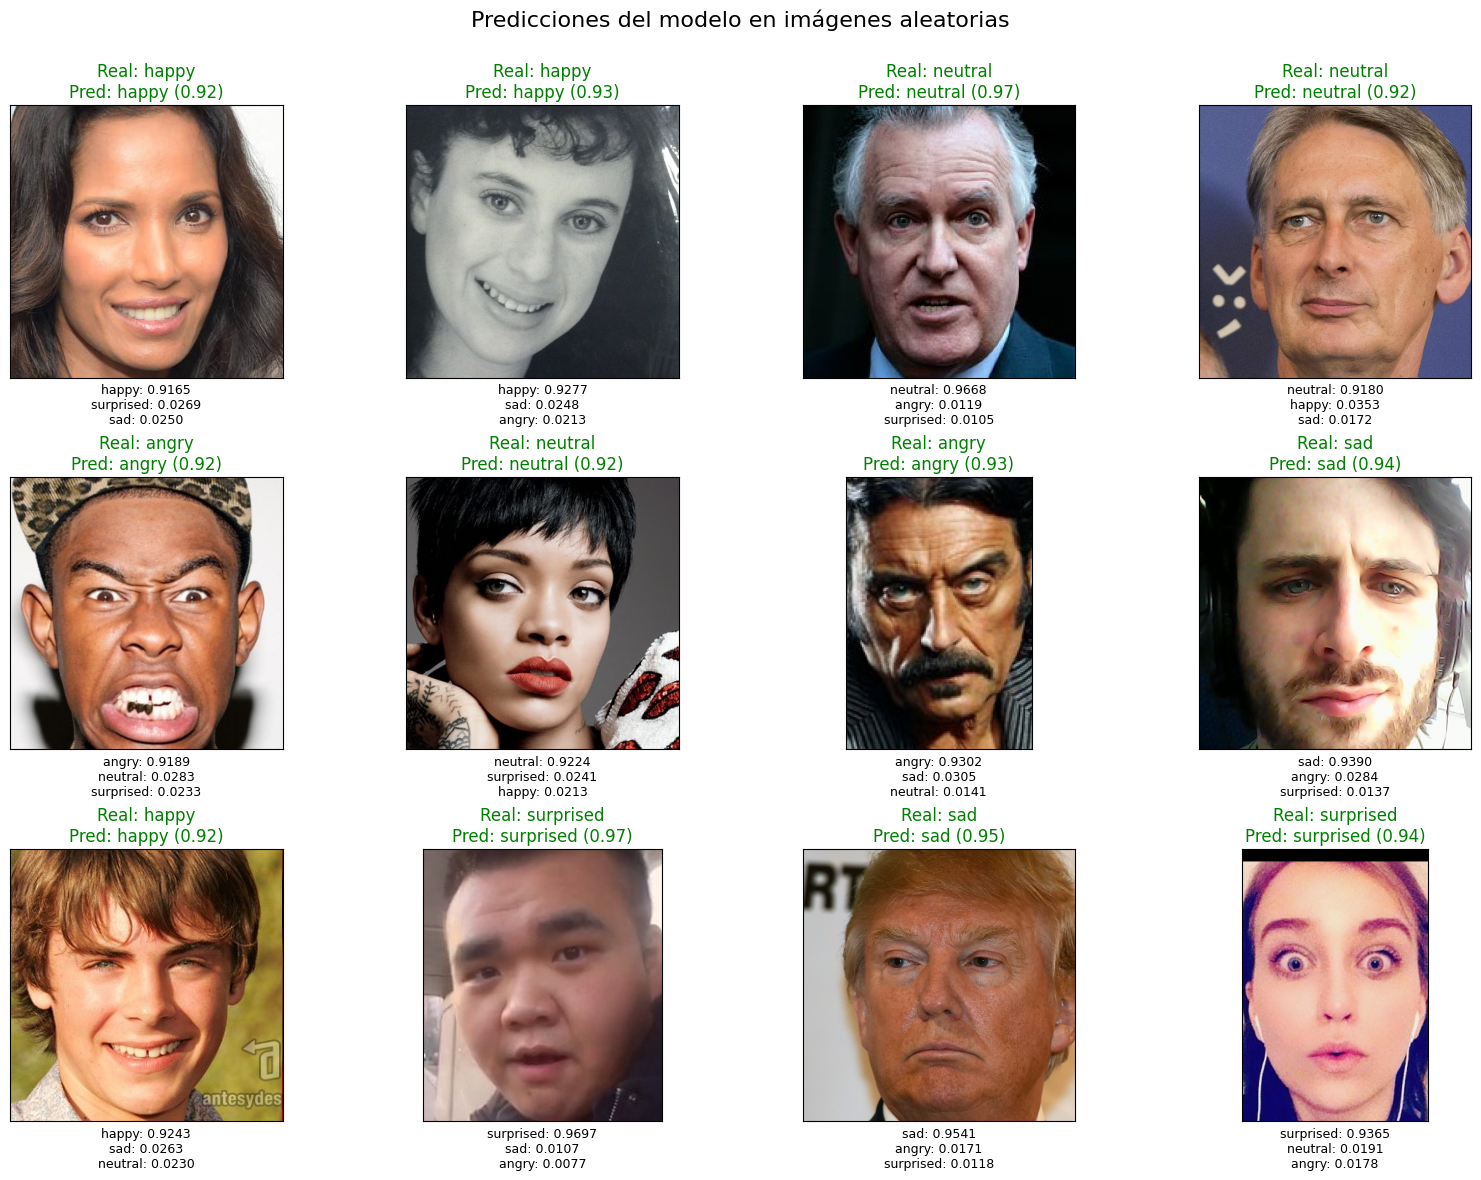

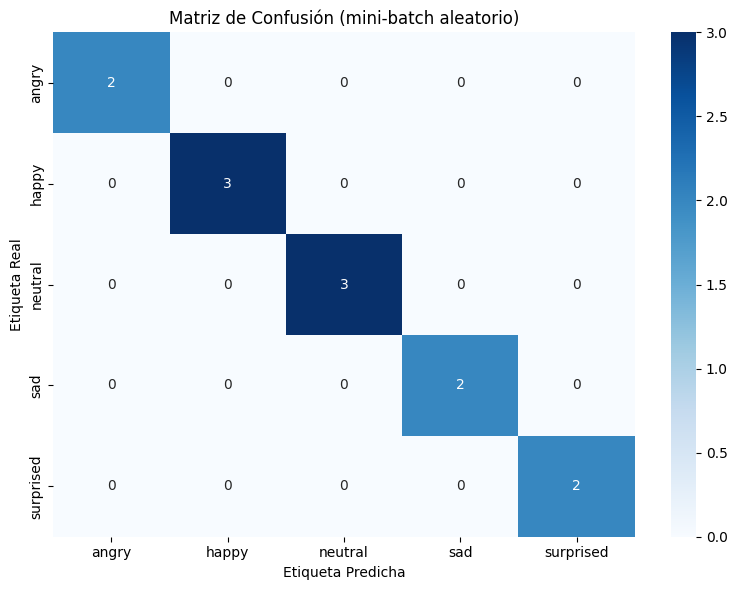

¡Todas las imágenes fueron clasificadas correctamente en este lote!

✅ Análisis del modelo completado


In [16]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model
import glob

# === CONFIGURACIÓN ===
# IMPORTANTE: Deshabilitar mixed precision para evitar problemas numéricos
print("Configurando policy de precisión a float32...")
tf.keras.mixed_precision.set_global_policy('float32')

# Rutas y parámetros
model_path = "final_best_model.keras"  # Usar el modelo original, no el de inferencia
dataset_path = "/kaggle/input/rolplay-fer-train/train"  # Ajusta esta ruta según tu setup
img_size = (224, 224)  # Tamaño que espera el modelo
num_samples = 12  # Número de imágenes aleatorias a visualizar

# Definir nombres de clases (asegurar que estén en el orden correcto)
class_names = ["angry", "happy", "neutral", "sad", "surprised"]

# === CARGAR MODELO ===
print("Cargando modelo...")
try:
    # Definir objetos personalizados si es necesario
    def f1_score(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        y_pred_one_hot = tf.one_hot(y_pred_labels, depth=tf.shape(y_pred)[-1])
        y_pred = tf.cast(y_pred_one_hot, tf.float32)

        true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
        predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))

        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1
    
    # Cargar modelo con objetos personalizados
    custom_objects = {'f1_score': f1_score}
    model = load_model(model_path, custom_objects=custom_objects)
    print("✅ Modelo cargado correctamente")
    
    # Verificar si hay NaNs en los pesos del modelo
    has_nan_weights = any(np.isnan(w).any() for w in model.get_weights())
    print(f"El modelo contiene pesos NaN: {has_nan_weights}")
    
    # Si hay pesos NaN, intentar cargar el otro modelo
    if has_nan_weights:
        print("Intentando cargar el modelo de inferencia como respaldo...")
        try:
            model = load_model("final_best_model_inference.keras", custom_objects=custom_objects)
            has_nan_weights = any(np.isnan(w).any() for w in model.get_weights())
            print(f"Modelo de inferencia cargado. Contiene pesos NaN: {has_nan_weights}")
        except Exception as e:
            print(f"No se pudo cargar modelo de inferencia: {e}")
    
    # Mostrar resumen del modelo
    model.summary()
except Exception as e:
    print(f"❌ Error al cargar el modelo: {e}")
    raise

# Configuración para crear un modelo de inferencia manual si es necesario
def create_inference_model(model):
    """Crea una copia del modelo con pesos idénticos pero específica para inferencia"""
    # Obtenemos la configuración y pesos
    config = model.get_config()
    weights = model.get_weights()
    
    # Creamos un nuevo modelo con la misma configuración
    inference_model = tf.keras.Model.from_config(config)
    inference_model.set_weights(weights)
    
    # Compilamos con las mismas métricas pero sin optimizador
    inference_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', f1_score]
    )
    
    return inference_model

# === SELECCIONAR IMÁGENES ALEATORIAS DEL DATASET ===
print("\nBuscando imágenes en el dataset...")

# Recopilar todas las imágenes por clase
images_by_class = {}
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.exists(class_dir):
        # Encontrar todas las imágenes (.jpg, .jpeg, .png)
        class_images = glob.glob(os.path.join(class_dir, '*.jpg')) + \
                      glob.glob(os.path.join(class_dir, '*.jpeg')) + \
                      glob.glob(os.path.join(class_dir, '*.png'))
        images_by_class[class_name] = class_images
        print(f"Clase {class_name}: {len(class_images)} imágenes encontradas")
    else:
        print(f"⚠️ Directorio no encontrado para clase {class_name}: {class_dir}")
        images_by_class[class_name] = []

# Verificar si encontramos imágenes
total_images = sum(len(imgs) for imgs in images_by_class.values())
if total_images == 0:
    print("❌ No se encontraron imágenes en el dataset")
    exit(1)
else:
    print(f"Total de imágenes encontradas: {total_images}")

# Seleccionar imágenes aleatorias de cada clase (tratando de balancear)
selected_images = []
images_per_class = max(1, num_samples // len(class_names))
remaining = num_samples - (images_per_class * len(class_names))

for class_name in class_names:
    class_images = images_by_class[class_name]
    if not class_images:
        continue
        
    # Seleccionar imágenes de esta clase
    num_to_select = min(images_per_class, len(class_images))
    selected = random.sample(class_images, num_to_select)
    
    for img_path in selected:
        selected_images.append((img_path, class_name))

# Si quedaron imágenes por seleccionar, agregar aleatoriamente de cualquier clase
if remaining > 0 and total_images > len(selected_images):
    all_images = []
    for class_name, images in images_by_class.items():
        for img in images:
            if (img, class_name) not in selected_images:
                all_images.append((img, class_name))
    
    extra_images = random.sample(all_images, min(remaining, len(all_images)))
    selected_images.extend(extra_images)

# Mezclar las imágenes seleccionadas
random.shuffle(selected_images)

# === PROCESAR Y PREDECIR ===
print(f"\nRealizando predicciones en {len(selected_images)} imágenes aleatorias...")

# Intentar crear un modelo de inferencia si el original no funciona bien
try:
    inference_model = create_inference_model(model)
    print("Modelo de inferencia manual creado correctamente")
except Exception as e:
    print(f"No se pudo crear modelo de inferencia manual: {e}")
    inference_model = model

predictions = []
images = []
true_labels = []
processed_images = []

# Desactivar verificaciones numéricas para evitar que TF se detenga por NaNs
tf.debugging.disable_check_numerics()

for img_path, true_class in selected_images:
    try:
        # Cargar imagen
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ No se pudo cargar la imagen: {img_path}")
            continue
            
        # Preprocesar imagen
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB
        img_resized = cv2.resize(img_rgb, img_size)  # Redimensionar
        img_normalized = img_resized.astype('float32') / 255.0  # Normalizar
        img_batch = np.expand_dims(img_normalized, axis=0)  # Añadir dimensión de batch
        
        # Intentar predecir con el modelo original primero (con training=False explícito)
        try:
            pred = model.predict(img_batch, verbose=0)[0]
            
            # Verificar si hay NaNs en la predicción
            if np.isnan(pred).any():
                print(f"Detectados NaN en predicción para {img_path}")
                # Intentar con el modelo de inferencia manual
                pred = inference_model(img_batch, training=False).numpy()[0]
                
                # Si aún hay NaNs, intentar como último recurso una implementación manual
                if np.isnan(pred).any():
                    print("Intentando implementación manual...")
                    # Hacer forward pass manualmente por capas
                    x = img_batch
                    for layer in model.layers:
                        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.Dropout):
                            x = layer(x, training=False)
                        else:
                            x = layer(x)
                    pred = x.numpy()[0]
                    
            # Si todavía hay NaN, asignar valores uniformes (mejor que nada)
            if np.isnan(pred).any():
                print("NaN persistente. Asignando valores uniformes.")
                pred = np.ones(len(class_names)) / len(class_names)
                
        except Exception as e:
            print(f"Error en predicción: {e}")
            # Asignar probabilidades uniformes en caso de error
            pred = np.ones(len(class_names)) / len(class_names)
        
        # Determinar clase predicha
        pred_class_idx = np.argmax(pred)
        pred_class = class_names[pred_class_idx]
        confidence = pred[pred_class_idx]
        
        # Guardar resultados
        predictions.append((pred_class, confidence, pred))
        images.append(img_rgb)
        true_labels.append(true_class)
        processed_images.append(img_normalized)
        
    except Exception as e:
        print(f"❌ Error procesando {img_path}: {e}")

# === VISUALIZAR RESULTADOS ===
if not predictions:
    print("❌ No se pudieron procesar imágenes para visualización")
    exit(1)

# Definir tamaño de la visualización
n_cols = 4
n_rows = (len(predictions) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, ((pred_class, confidence, pred_scores), img, true_class) in enumerate(zip(predictions, images, true_labels)):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Mostrar imagen
    plt.imshow(img)
    
    # Determinar color según predicción (verde si es correcta, rojo si es incorrecta)
    color = 'green' if pred_class == true_class else 'red'
    
    # Preparar texto con predicción y confianza
    confidence_text = f"{confidence:.2f}" if not np.isnan(confidence) else "NaN"
    title = f"Real: {true_class}\nPred: {pred_class} ({confidence_text})"
    
    # Mostrar top 3 predicciones
    top_k = 3
    top_indices = np.argsort(pred_scores)[-top_k:][::-1]
    pred_text = "\n".join([f"{class_names[idx]}: {pred_scores[idx]:.4f}" for idx in top_indices if not np.isnan(pred_scores[idx])])
    
    plt.title(title, color=color)
    plt.xlabel(pred_text, fontsize=9)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.suptitle("Predicciones del modelo en imágenes aleatorias", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# === MOSTRAR MATRIZ DE CONFUSIÓN DE ESTE MINI-BATCH ===
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convertir etiquetas de texto a índices
y_true = [class_names.index(label) for label in true_labels]
y_pred = [class_names.index(pred[0]) for pred in predictions]

# Crear matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Mostrar matriz con porcentajes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión (mini-batch aleatorio)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# === MOSTRAR IMÁGENES MAL CLASIFICADAS ===
misclassified_indices = [i for i, (pred, true) in enumerate(zip([p[0] for p in predictions], true_labels)) if pred != true]

if misclassified_indices:
    print(f"\nImágenes mal clasificadas: {len(misclassified_indices)} de {len(predictions)}")
    
    n_cols_wrong = min(3, len(misclassified_indices))
    n_rows_wrong = (len(misclassified_indices) + n_cols_wrong - 1) // n_cols_wrong
    
    plt.figure(figsize=(n_cols_wrong * 4, n_rows_wrong * 4))
    
    for i, idx in enumerate(misclassified_indices):
        pred_class, confidence, pred_scores = predictions[idx]
        img = images[idx]
        true_class = true_labels[idx]
        
        plt.subplot(n_rows_wrong, n_cols_wrong, i + 1)
        plt.imshow(img)
        
        # Mostrar todas las probabilidades que no sean NaN
        valid_scores = [(class_names[j], score) for j, score in enumerate(pred_scores) if not np.isnan(score)]
        pred_text = "\n".join([f"{cls}: {score:.4f}" for cls, score in valid_scores])
        
        confidence_text = f"{confidence:.4f}" if not np.isnan(confidence) else "NaN"
        plt.title(f"Real: {true_class}\nPred: {pred_class} ({confidence_text})", color='red')
        plt.xlabel(pred_text, fontsize=9)
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.suptitle("Imágenes mal clasificadas (análisis detallado)", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("¡Todas las imágenes fueron clasificadas correctamente en este lote!")

print("\n✅ Análisis del modelo completado")